<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/Residual_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Module

## Introduction

In this notebook, we explore the training of a neural network using residual modules. Residual modules, inspired by residual learning, address the vanishing gradient problem and improve the network's ability to capture complex patterns. By implementing and integrating these modules, we aim to enhance the network's performance and showcase their effectiveness in deep learning architectures.

## How it works

Residual modules are based on the introduction of a shortcut connections that allow information to bypass certain layers in the network. Instead of solely relying on the output of the previous layer, residual modules incorporate the original input data as well. By adding the input data to the output of a layer, the module enables the network to learn residual functions that focus on the differences between the input and output. 
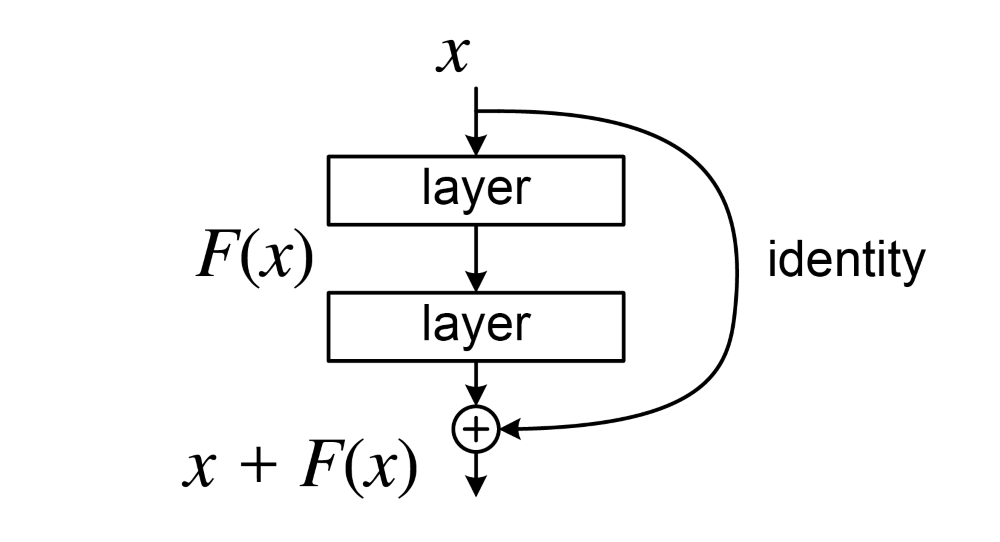

This approach facilitates the learning process, especially when dealing with deep networks, by mitigating the vanishing gradient problem. Residual modules have proven effective in improving gradient flow, enhancing feature extraction, and enabling better model optimization, ultimately leading to improved performance in various tasks.


#Setup

## Import libraries

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime
from keras.utils import plot_model

## Unzip preprocessed dataset

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [ ]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8
RANDOM_SEED = 42

## Load dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [ ]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [ ]:
def eval (model):
  y_score = model.predict(test_dataset)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

# Residual Module implementation 

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

In [ ]:
def residual_module(layer_in, filters, strides=1, activation='relu'):
 merge_input = layer_in

 if layer_in.shape[-1] != filters:
  merge_input = layers.Conv2D(filters, (1,1), padding='same', activation='relu', strides=strides)(layer_in)

 conv1 = layers.Conv2D(filters, (3,3), padding='same', activation='relu', strides=strides)(layer_in)
 conv2 = layers.Conv2D(filters, (3,3), padding='same', activation='relu', strides=strides)(conv1)

 layer_out = layers.add([conv2, merge_input])
 layer_out = layers.Activation(activation)(layer_out)
 return layer_out

## Model definition

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 224, 224, 3)  0           ['input_18[0][0]']               
                                                                                                  
 conv2d_193 (Conv2D)            (None, 224, 224, 32  896         ['sequential_3[0][0]']           
                                )                                                                 
                                                                                           

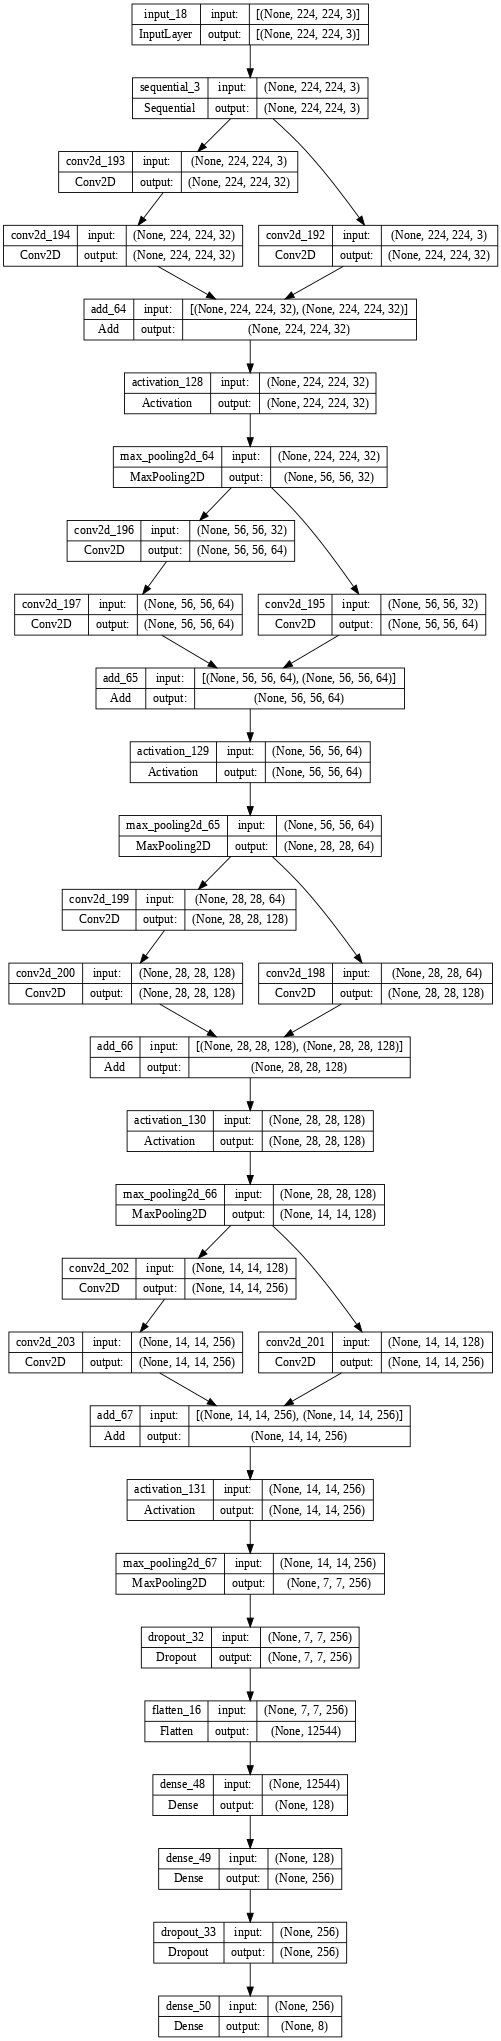

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = residual_module(x, 32)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)
x = residual_module(x, 64)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_module(x, 128)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_module(x, 256)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "residual_module"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'residual_module.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.9102 - accuracy: 0.2418
Epoch 1: val_loss improved from inf to 1.66223, saving model to /content/drive/My Drive/project/models/residual_module/residual_module.h5
55/55 [==============================] - 65s 713ms/step - loss: 1.9102 - accuracy: 0.2418 - val_loss: 1.6622 - val_accuracy: 0.3782
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.5319 - accuracy: 0.4413
Epoch 2: val_loss improved from 1.66223 to 1.48664, saving model to /content/drive/My Drive/project/models/residual_module/residual_module.h5
55/55 [==============================] - 38s 645ms/step - loss: 1.5319 - accuracy: 0.4413 - val_loss: 1.4866 - val_accuracy: 0.4753
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3592 - accuracy: 0.5115
Epoch 3: val_loss improved from 1.48664 to 1.36838, saving model to /content/drive/My Drive/project/models/residual_module/residual_module.h5
55/55 [======================

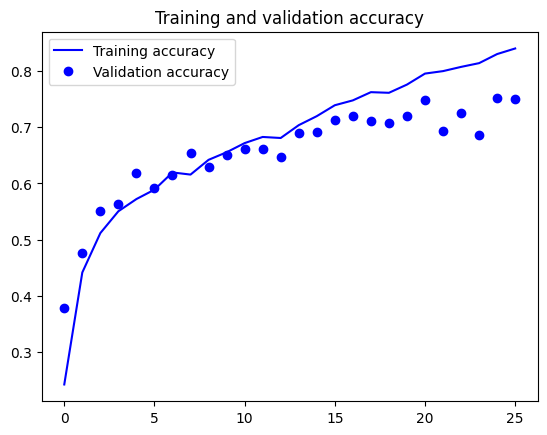

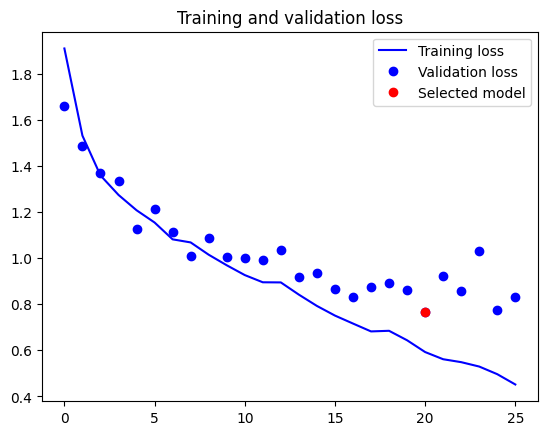

Lowest validation loss has been reached at epoch 20 with validation accuracy of 0.749


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 5s 219ms/step - loss: 0.7013 - accuracy: 0.7573
Test accuracy: 0.757, test loss: 0.701
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 3]
              precision    recall  f1-score   support

           0     0.2505    0.8163    0.3834       147
           1     0.9561    0.7842    0.8617      1112
           2     0.8785    0.5502    0.6766       289
           3     0.7174    0.3367    0.4583        98
           4     0.7165    0.8424    0.7744       165
           5     0.7517    0.7465    0.7491       288
           6     0.5197    0.5038    0.5116       131
           7     0.6408    0.6735    0.6567        98

    accuracy                         0.7174      2328
   macro avg     0.6789    0.6567    0.6340      2328
weighted avg     0.8118    0.7174    0.7431      2328



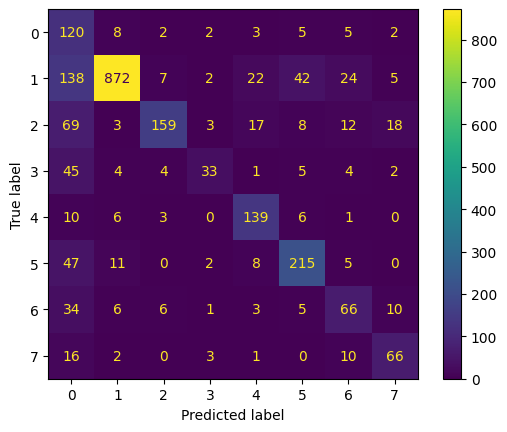

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

The results show good performances on both the validation and test sets, with a training process of 26 epochs. To improve the model's performance, it may be beneficial to increase the complexity of the model.

# Residual Module Deeper implementation 

## Model definition

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv2d_107 (Conv2D)            (None, 224, 224, 32  896         ['sequential[10][0]']            
                                )                                                                 
                                                                                            

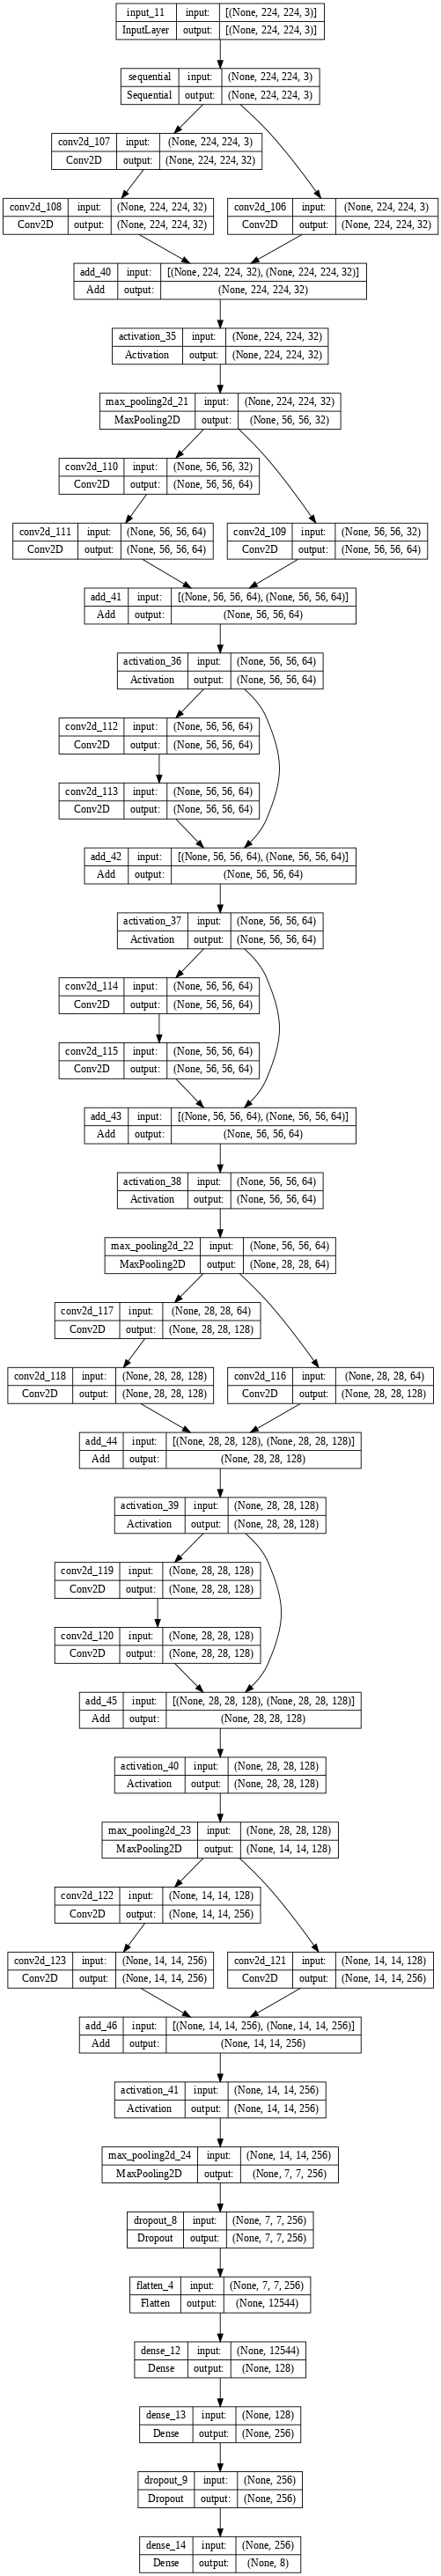

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = residual_module(x, 32)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)
x = residual_module(x, 64)
x = residual_module(x, 64)
x = residual_module(x, 64)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_module(x, 128)
x = residual_module(x, 128)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_module(x, 256)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "residual_module_deeper"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'residual_module_deeper.png')

if not os.path.exists(model_path):
  os.makedirs(model_path)

plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.8589 - accuracy: 0.2786
Epoch 1: val_loss improved from inf to 1.72840, saving model to /content/drive/My Drive/project/models/residual_module_deeper/residual_module_deeper.h5
55/55 [==============================] - 77s 803ms/step - loss: 1.8589 - accuracy: 0.2786 - val_loss: 1.7284 - val_accuracy: 0.3657
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.5156 - accuracy: 0.4392
Epoch 2: val_loss improved from 1.72840 to 1.49515, saving model to /content/drive/My Drive/project/models/residual_module_deeper/residual_module_deeper.h5
55/55 [==============================] - 43s 764ms/step - loss: 1.5156 - accuracy: 0.4392 - val_loss: 1.4952 - val_accuracy: 0.4706
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3301 - accuracy: 0.5214
Epoch 3: val_loss improved from 1.49515 to 1.35810, saving model to /content/drive/My Drive/project/models/residual_module_deeper/residual_modu

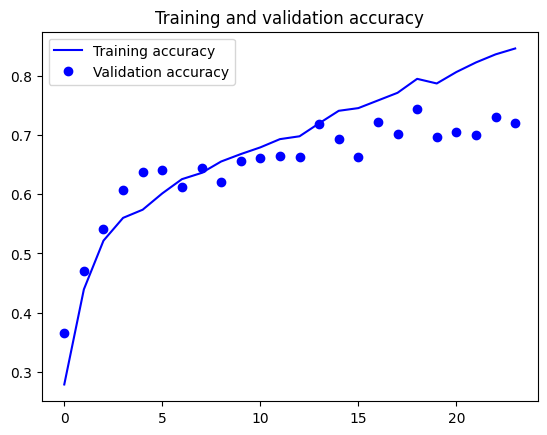

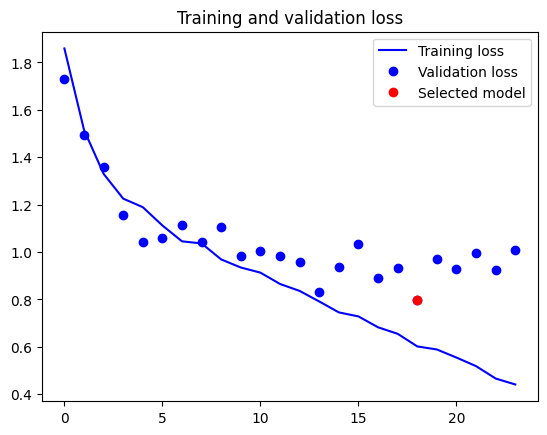

Lowest validation loss has been reached at epoch 18 with validation accuracy of 0.743


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 4s 187ms/step - loss: 0.7331 - accuracy: 0.7577
Test accuracy: 0.758, test loss: 0.733
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.2599    0.8027    0.3927       147
           1     0.9441    0.8049    0.8689      1112
           2     0.8116    0.5813    0.6774       289
           3     0.5714    0.3673    0.4472        98
           4     0.6604    0.8485    0.7427       165
           5     0.7254    0.7153    0.7203       288
           6     0.6627    0.4198    0.5140       131
           7     0.7403    0.5816    0.6514        98

    accuracy                         0.7195      2328
   macro avg     0.6720    0.6402    0.6268      2328
weighted avg     0.7972    0.7195    0.7409      2328



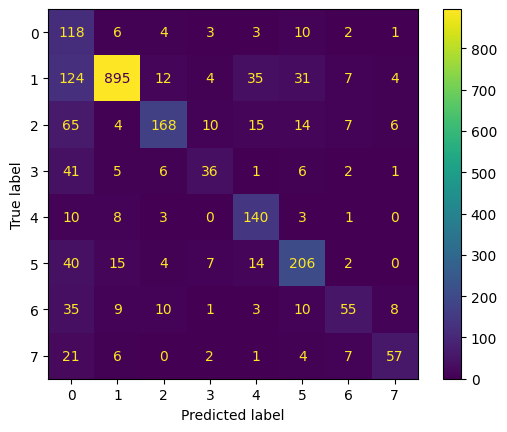

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations


Increasing the complexity of the model did not lead to significant improvements in performance; instead, it increased overfitting.


#Hyperparameter tuning

## Setup

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

my_dir = "/content/drive/My Drive/tuner"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

## Model builder

In [ ]:
def model_builder(hp):
  # Hyperparameter 
  activation_hp = hp.Choice('activation_function', values=['relu', 'elu', 'gelu'])
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  dropout_rate_hp1 = hp.Float('dropout_rate1', min_value = 0, max_value = 0.5)
  dropout_rate_hp2 = hp.Float('dropout_rate2', min_value = 0, max_value = 0.5)

  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  x = resize_and_rescale(inputs)
  x = residual_module(x, 32, activation=activation_hp)
  x = layers.MaxPooling2D(pool_size=(4, 4))(x)
  x = residual_module(x, 64, activation=activation_hp)
  x = residual_module(x, 64, activation=activation_hp)
  x = residual_module(x, 64, activation=activation_hp)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = residual_module(x, 128, activation=activation_hp)
  x = residual_module(x, 128, activation=activation_hp)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = residual_module(x, 256, activation=activation_hp)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = layers.Dropout(dropout_rate_hp1)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(hp_units1)(x)
  x = layers.Dense(hp_units2)(x)
  x = layers.Dropout(dropout_rate_hp2)(x)

  outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='residual_module_hptuning')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hyperparameter tuning

In [ ]:
stop_early = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=25,
                     factor=3,
                     directory=log_dir,
                     project_name='model_tuned')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'gelu'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
dropout_rate2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


Perform search for the best hyperparameters. 

In [ ]:
tuner.search(train_dataset, epochs=25, validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units1')}, \
        The optimal number of units in the second densely-connected layer is {best_hps.get('units2')}, \
        The optimal activation function is {best_hps.get('activation_function')}, \
        The optimal first dropout value is  {best_hps.get('dropout_rate1')}, \
        The optimal second dropout value is  {best_hps.get('dropout_rate2')}, \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

Trial 30 Complete [00h 24m 27s]
val_accuracy: 0.709926962852478

Best val_accuracy So Far: 0.72883540391922
Total elapsed time: 03h 31m 27s
The hyperparameter search is complete.         The optimal number of units in the first densely-connected layer is 384,         The optimal number of units in the second densely-connected layer is 64,         The optimal activation function is relu,         The optimal first dropout value is  0.44303667898306826,         The optimal second dropout value is  0.25590754133757243,         the optimal learning rate for the optimizer is 0.0001.


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/My Drive/tuner/logs/0514-1427/model_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
activation_function: relu
units1: 384
units2: 64
learning_rate: 0.0001
dropout_rate1: 0.44303667898306826
dropout_rate2: 0.25590754133757243
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.72883540391922

Trial 0016 summary
Hyperparameters:
activation_function: elu
units1: 128
units2: 256
learning_rate: 0.0001
dropout_rate1: 0.2624495347567594
dropout_rate2: 0.10516997993458432
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.7241082787513733

Trial 0025 summary
Hyperparameters:
activation_function: relu
units1: 192
units2: 448
learning_rate: 0.0001
dropout_rate1: 0.302977237341898
dropout_rate2: 0.24817327518082866
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner

## Train model with the best hyperparameters

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=stop_early)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
55/55 [==============================] - 51s 773ms/step - loss: 2.0856 - accuracy: 0.2376 - val_loss: 1.6106 - val_accuracy: 0.4349
Epoch 2/50
55/55 [==============================] - 45s 788ms/step - loss: 1.5451 - accuracy: 0.4311 - val_loss: 1.3410 - val_accuracy: 0.5239
Epoch 3/50
55/55 [==============================] - 43s 772ms/step - loss: 1.3927 - accuracy: 0.4938 - val_loss: 1.2542 - val_accuracy: 0.5638
Epoch 4/50
55/55 [==============================] - 43s 765ms/step - loss: 1.2773 - accuracy: 0.5439 - val_loss: 1.2848 - val_accuracy: 0.5617
Epoch 5/50
55/55 [==============================] - 43s 768ms/step - loss: 1.1812 - accuracy: 0.5837 - val_loss: 1.2139 - val_accuracy: 0.5926
Epoch 6/50
55/55 [==============================] - 44s 771ms/step - loss: 1.1368 - accuracy: 0.5996 - val_loss: 1.0898 - val_accuracy: 0.6296
Epoch 7/50
55/55 [==============================] - 44s 791ms/step - loss: 1.0703 - accuracy: 0.6196 - val_loss: 1.3137 - val_accuracy: 0.5475

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset, callbacks=stop_early)

Epoch 1/22
55/55 [==============================] - 52s 783ms/step - loss: 2.1201 - accuracy: 0.2145 - val_loss: 1.8630 - val_accuracy: 0.2888
Epoch 2/22
55/55 [==============================] - 44s 776ms/step - loss: 1.6136 - accuracy: 0.4031 - val_loss: 1.7856 - val_accuracy: 0.3636
Epoch 3/22
55/55 [==============================] - 43s 761ms/step - loss: 1.4073 - accuracy: 0.4974 - val_loss: 1.3319 - val_accuracy: 0.5462
Epoch 4/22
55/55 [==============================] - 43s 761ms/step - loss: 1.2803 - accuracy: 0.5477 - val_loss: 1.2382 - val_accuracy: 0.5801
Epoch 5/22
55/55 [==============================] - 43s 761ms/step - loss: 1.2021 - accuracy: 0.5754 - val_loss: 1.2577 - val_accuracy: 0.5844
Epoch 6/22
55/55 [==============================] - 43s 759ms/step - loss: 1.1509 - accuracy: 0.5885 - val_loss: 1.1713 - val_accuracy: 0.5982
Epoch 7/22
55/55 [==============================] - 43s 758ms/step - loss: 1.1060 - accuracy: 0.6125 - val_loss: 1.3156 - val_accuracy: 0.5578

In [ ]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

19/19 [==============================] - 5s 268ms/step - loss: 0.7377 - accuracy: 0.7513
[test loss, test accuracy]: [0.7376615405082703, 0.751288652420044]
